In [1]:
%matplotlib inline

import os
import datacube
import xarray as xr
import geopandas as gpd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import matplotlib.pyplot as plt
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.load_era5 import load_era5
from deafrica_tools.plotting import display_map, rgb
from statsmodels.tsa.seasonal import seasonal_decompose

from odc.geo.geom import Geometry
from deafrica_tools.areaofinterest import define_area



In [2]:
dc = datacube.Datacube(app="heatwave_detection")

In [16]:
#method1; specify the lat,ln,and buffer
aoi= define_area(lat= 13.9874,lon=3.4497, buffer=0.06)


#method 2; use a polygon as a GeoJSON OR ESRI shapefile
#aoi=define_area


#create a geopoly and geodataframe of the area of interest
geopolygon=Geometry(aoi["features"][0]["geometry"],crs="epsg:4326")
geopolygon_gdf= gpd.GeoDataFrame(geometry=[geopolygon],crs=geopolygon.crs)

# get the lat and lon range of the geopolygon
lat_range=(geopolygon_gdf.total_bounds[1],geopolygon_gdf.total_bounds[3])
lon_range=(geopolygon_gdf.total_bounds[0],geopolygon_gdf.total_bounds[2])

In [17]:
display_map(lon_range,lat_range)

In [18]:
ds= load_ard(dc=dc,products=['ls5_st'],
            measurements=['surface_temperature'],
            output_crs='EPSG:6933',
            y=lat_range,
            x=lon_range,
            resolution=(-30,30),
            group_by='solar_day',
            time=('2000',"2023"),
             min_gooddata= 1      #for cloudfree images
            ) 

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls5_st
Counting good quality pixels for each time step
Filtering to 20 out of 27 time steps with at least 100.0% good quality pixels
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Loading 20 time steps


In [19]:
temp=ds['surface_temperature']
temp

<xarray.DataArray 'surface_temperature' (time: 20, y: 496, x: 387)> Size: 15MB
array([[[318.75256, 318.3116 , 316.8487 , ..., 317.42633, 317.59726,
         317.59726],
        [318.75256, 318.75256, 316.7359 , ..., 317.42633, 317.59726,
         317.59726],
        [318.75256, 318.75256, 316.83502, ..., 317.86386, 318.03476,
         318.03476],
        ...,
        [318.94055, 318.94055, 318.46884, ..., 319.32678, 319.7848 ,
         320.2223 ],
        [319.09094, 318.6466 , 318.24667, ..., 319.32678, 319.7848 ,
         320.2223 ],
        [318.65002, 318.65002, 318.2501 , ..., 319.32678, 319.7848 ,
         320.2223 ]],

       [[310.78174, 310.78174, 309.39743, ..., 309.48288, 309.65036,
         309.65036],
        [311.2295 , 311.2295 , 309.38718, ..., 309.48288, 309.65036,
         309.65036],
        [311.67725, 311.2295 , 309.9033 , ..., 309.48288, 310.0981 ,
         310.0981 ],
...
        [311.4995 , 311.4995 , 311.4756 , ..., 311.98828, 312.0088 ,
         312.4668 ],
        [311.22266, 311.22266, 311.26367, ..., 311.98828, 312.0088 ,
         312.4668 ],
        [311.22266, 311.22266, 310.80225, ..., 311.98828, 312.0088 ,
         312.4668 ]],

       [[297.43777, 297.43777, 296.3098 , ..., 299.075  , 299.2254 ,
         299.721  ],
        [297.94363, 297.94363, 296.29956, ..., 299.075  , 299.2254 ,
         299.721  ],
        [297.94363, 297.94363, 296.3098 , ..., 299.5672 , 299.721  ,
         299.721  ],
        ...,
        [298.5213 , 298.5213 , 298.49738, ..., 296.60034, 296.62085,
         297.1233 ],
        [298.26154, 298.26154, 298.30255, ..., 296.60034, 296.62085,
         297.1233 ],
        [298.26154, 298.26154, 298.30255, ..., 296.60034, 296.62085,
         297.1233 ]]], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 160B 2006-11-04T10:01:28.529063 ... 20...
  * y            (y) float64 4kB 1.775e+06 1.775e+06 ... 1.76e+06 1.76e+06
  * x            (x) float64 3kB 3.27e+05 3.271e+05 ... 3.386e+05 3.386e+05
    spatial_ref  int32 4B 6933
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

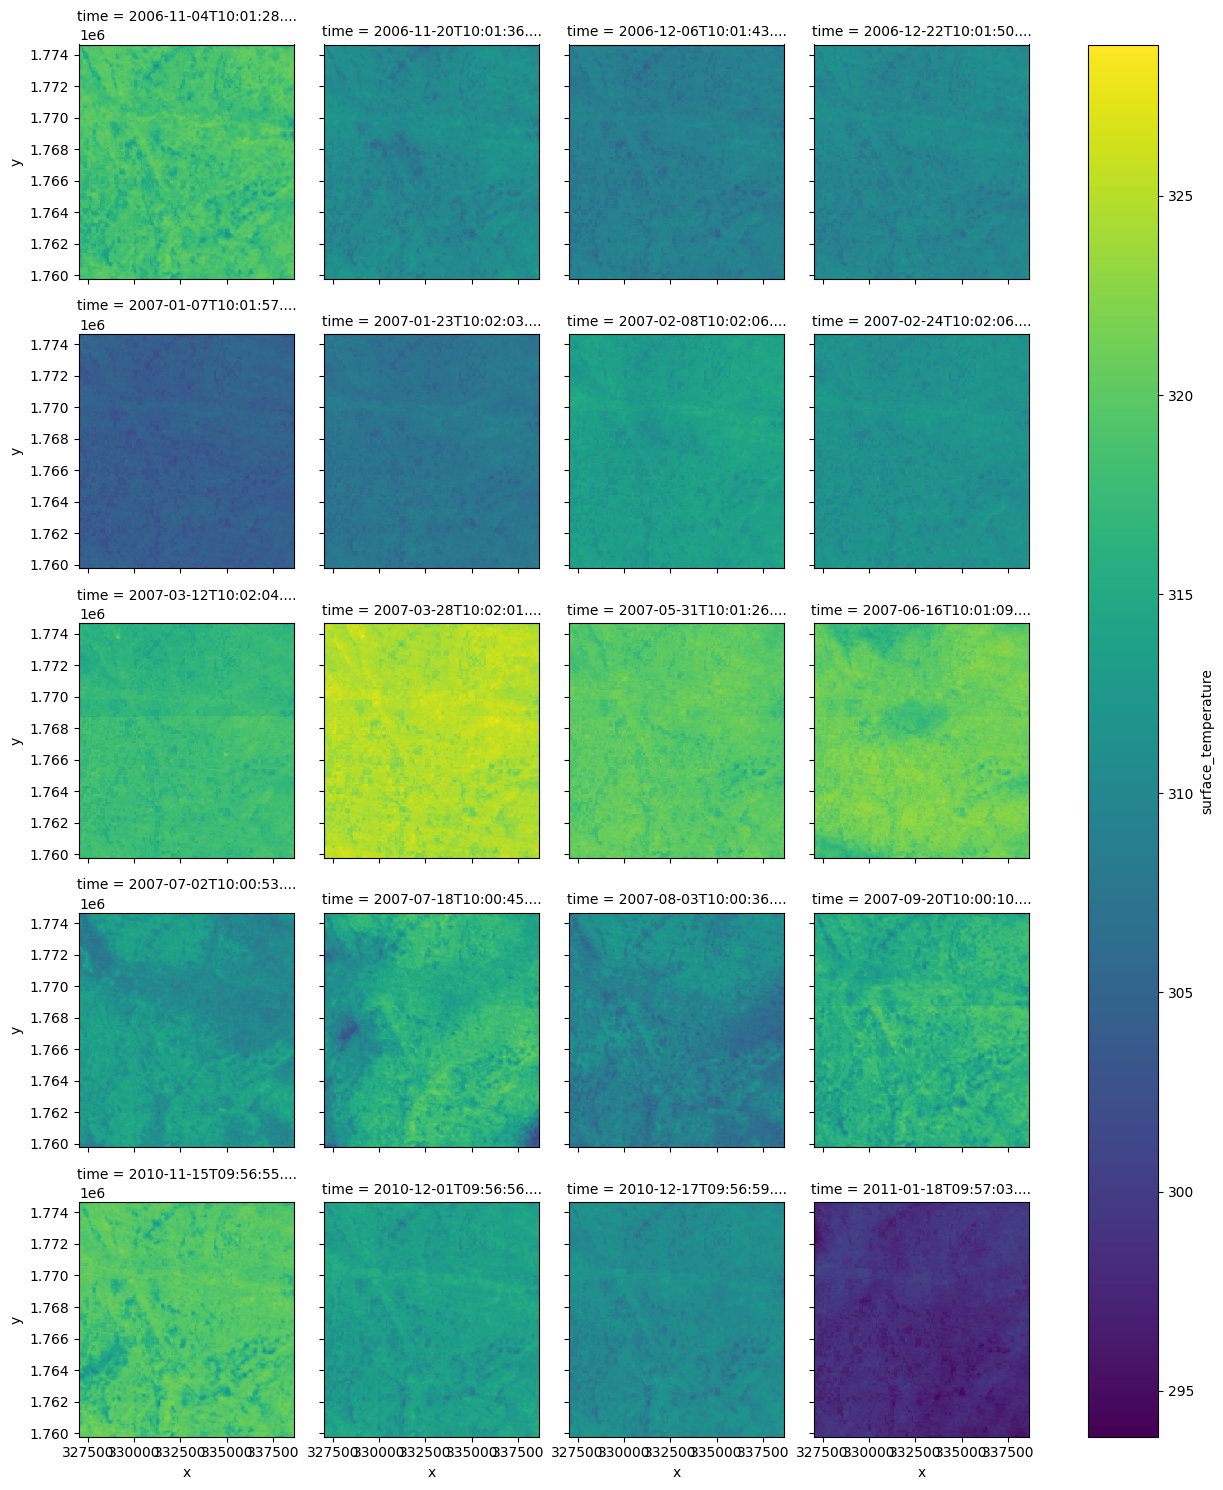

In [20]:
temp.plot(col='time',col_wrap=4)

In [21]:
temp_celsius = ds['surface_temperature'] - 273.15
temp_celsius

<xarray.DataArray 'surface_temperature' (time: 20, y: 496, x: 387)> Size: 15MB
array([[[45.60257 , 45.16162 , 43.6987  , ..., 44.276337, 44.447266,
         44.447266],
        [45.60257 , 45.60257 , 43.585907, ..., 44.276337, 44.447266,
         44.447266],
        [45.60257 , 45.60257 , 43.685028, ..., 44.713867, 44.884766,
         44.884766],
        ...,
        [45.790558, 45.790558, 45.318848, ..., 46.17679 , 46.634796,
         47.072296],
        [45.94095 , 45.496613, 45.09668 , ..., 46.17679 , 46.634796,
         47.072296],
        [45.50003 , 45.50003 , 45.100098, ..., 46.17679 , 46.634796,
         47.072296]],

       [[37.631744, 37.631744, 36.247437, ..., 36.332886, 36.500366,
         36.500366],
        [38.0795  , 38.0795  , 36.237183, ..., 36.332886, 36.500366,
         36.500366],
        [38.527252, 38.0795  , 36.753296, ..., 36.332886, 36.94812 ,
         36.94812 ],
...
        [38.349518, 38.349518, 38.325592, ..., 38.838287, 38.858795,
         39.316803],
        [38.072662, 38.072662, 38.113678, ..., 38.838287, 38.858795,
         39.316803],
        [38.072662, 38.072662, 37.652252, ..., 38.838287, 38.858795,
         39.316803]],

       [[24.28778 , 24.28778 , 23.15982 , ..., 25.925018, 26.075409,
         26.571014],
        [24.79364 , 24.79364 , 23.149567, ..., 25.925018, 26.075409,
         26.571014],
        [24.79364 , 24.79364 , 23.15982 , ..., 26.417206, 26.571014,
         26.571014],
        ...,
        [25.371307, 25.371307, 25.347382, ..., 23.450348, 23.470856,
         23.973297],
        [25.111542, 25.111542, 25.152557, ..., 23.450348, 23.470856,
         23.973297],
        [25.111542, 25.111542, 25.152557, ..., 23.450348, 23.470856,
         23.973297]]], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 160B 2006-11-04T10:01:28.529063 ... 20...
  * y            (y) float64 4kB 1.775e+06 1.775e+06 ... 1.76e+06 1.76e+06
  * x            (x) float64 3kB 3.27e+05 3.271e+05 ... 3.386e+05 3.386e+05
    spatial_ref  int32 4B 6933

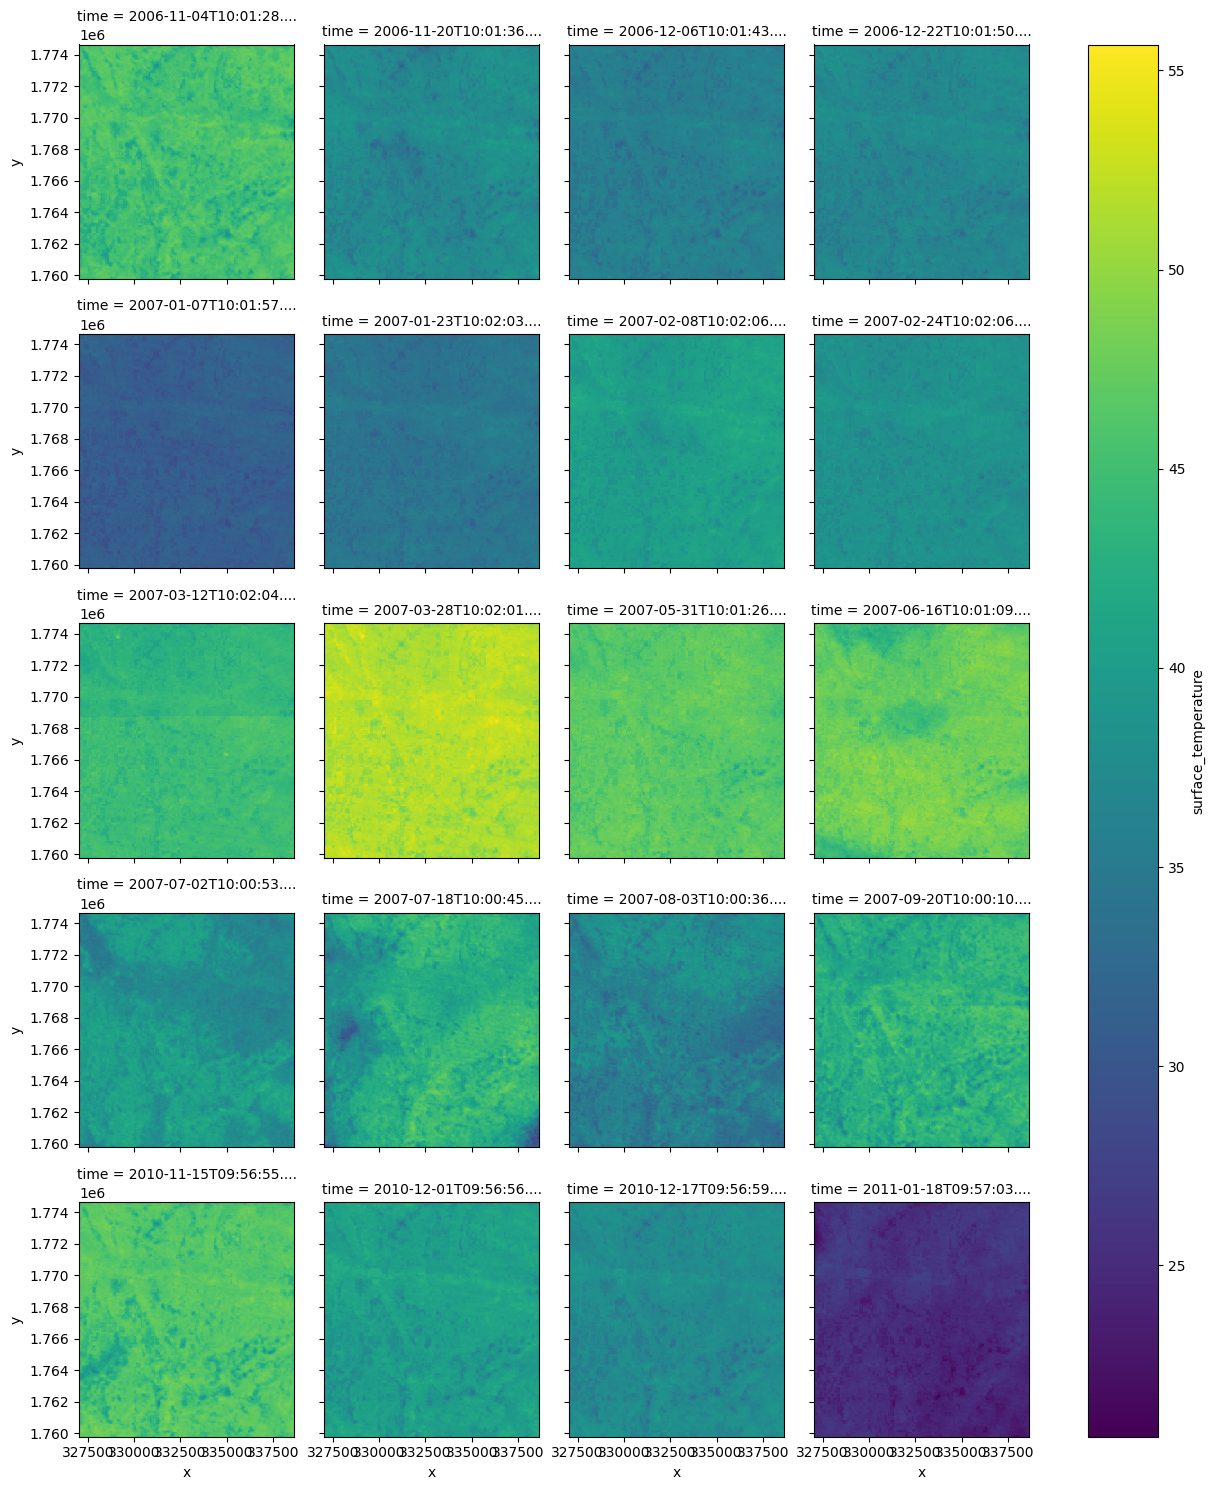

In [22]:
temp_celsius.plot(col='time',col_wrap=4)

In [23]:
heatwave_threshold = np.percentile(temp_celsius, 90)
heatwave_threshold

47.205596923828125

In [30]:
print(f"90th percentile threshold: {heatwave_threshold:.2f} °C")

90th percentile threshold: 47.21 °C


In [24]:
# Create a mask where temperature exceeds threshold
heatwave_mask = temp_celsius > heatwave_threshold

# Find consecutive heatwave days
from scipy.ndimage import label

# Label consecutive days of heatwave
labeled_array, num_features = label(heatwave_mask)

# Count number of days in each heatwave event
heatwave_events = []
for i in range(1, num_features + 1):
    event_size = np.sum(labeled_array == i)
    if event_size >= 3:  # Keep only events lasting at least 3 days
        heatwave_events.append(event_size)

print(f"Number of heatwave events: {len(heatwave_events)}")

Number of heatwave events: 551


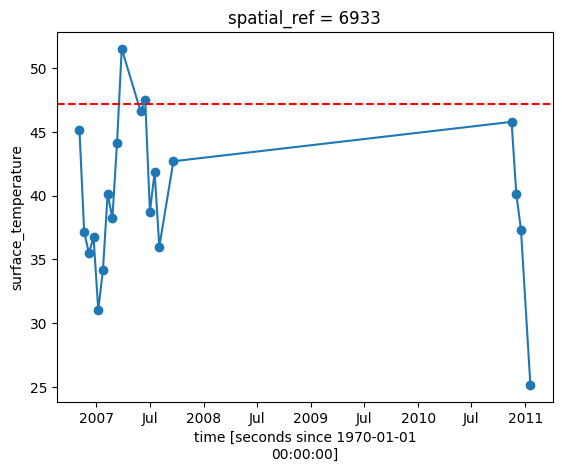

In [29]:
temp_celsius.mean(['x','y']).plot.line("-o")
plt.axhline(heatwave_threshold, color='r', linestyle='--', label='Heatwave Threshold (90th percentile)')
